# Compare Madrasin vs no Madrasin in the no DMS samples around exon-intron boundaries

## Purpose
Aim of this script is to get the ratio of Madrasin to non Madrasin reads around exon-intron boundaries in samples not treated with DMS

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/ExonIntronCoords_GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/ExonIntronCoords_GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(1859728, 2)


In [5]:
if feature=="Gene":
    fileToRead="quant.genes.sf"
else:
    fileToRead="quant.sf"

In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [7]:
# which end
whichend=str(3)

In [8]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if ("transcripts_quant_genenames_AgainstUnique"+whichend+"pExonIntronBoundaryCoordinates" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        #print data_to_read.head()
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        #print data_to_read.head()
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        #print data_to_read_sorted.head()
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

All_Minusfiles_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates


In [9]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

68


In [10]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("transcripts_quant_genenames_AgainstUnique"+whichend+"pExonIntronBoundaryCoordinates" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

All_Minusfiles_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames_AgainstUnique3pExonIntronBoundaryCoordinates


In [11]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(68, 7)


,All_Minusfiles,Mad-10mm-8hr-minus_S10,Mad-30mm-8hr-DMS_S9,Mad-20mm-4hr-minus_S5,Mad-30mm-4hr-minus_S6,Mad-20mm-8hr-minus_S11,Mad-10mm-4hr-minus_S4
ACTB,6508.170,7076.600,6926.160,7485.610,6753.180,6491.600,6184.910
ADAR,904.223,944.460,877.560,985.157,926.761,849.549,1013.710
ATP5F1B,1282.590,1700.060,2163.430,1525.590,1453.550,1236.600,1366.480
CALR,876.662,1133.350,1255.340,1073.710,1073.090,759.358,847.125
CD48,711.824,710.094,909.041,683.522,777.178,1105.580,744.336


In [12]:
sorted_columns = sorted(list(feature_readCounts_transcriptome.columns.values))
sorted_columns_NoControl = [i for i in sorted_columns if "All" not in i]

In [13]:
feature_readCounts_transcriptome_MadrasinData = feature_readCounts_transcriptome[sorted_columns_NoControl]
print feature_readCounts_transcriptome_MadrasinData.shape
feature_readCounts_transcriptome_MadrasinData.head()

(68, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,6184.910,7076.600,7485.610,6491.600,6753.180,6926.160
ADAR,1013.710,944.460,985.157,849.549,926.761,877.560
ATP5F1B,1366.480,1700.060,1525.590,1236.600,1453.550,2163.430
CALR,847.125,1133.350,1073.710,759.358,1073.090,1255.340
CD48,744.336,710.094,683.522,1105.580,777.178,909.041


In [14]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin
ratios_readCounts = feature_readCounts_transcriptome_MadrasinData.divide(feature_readCounts_transcriptome["All_Minusfiles"],axis=0)
print ratios_readCounts.shape
ratios_readCounts.head()

(68, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,0.950330,1.087341,1.150187,0.997454,1.037647,1.064225
ADAR,1.121084,1.044499,1.089507,0.939535,1.024925,0.970513
ATP5F1B,1.065407,1.325490,1.189460,0.964143,1.133293,1.686767
CALR,0.966307,1.292802,1.224771,0.866192,1.224064,1.431954
CD48,1.045674,0.997570,0.960240,1.553165,1.091812,1.277059


In [15]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.mean,axis=0)
ratios_readCounts_avg

Mad-10mm-4hr-minus_S4     1.007380
Mad-10mm-8hr-minus_S10    1.153489
Mad-20mm-4hr-minus_S5     1.115622
Mad-20mm-8hr-minus_S11    0.911155
Mad-30mm-4hr-minus_S6     1.088412
Mad-30mm-8hr-DMS_S9       1.322941
dtype: float64

['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


/usr/local/lib/python2.7/dist-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


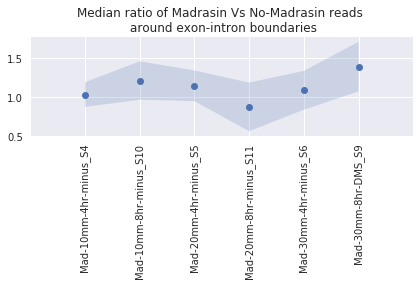

In [16]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n around exon-intron boundaries")
plt.savefig("../results/MedianRatio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


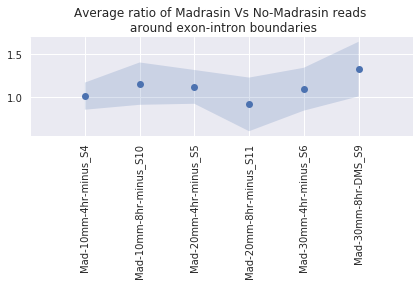

In [17]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Average ratio of Madrasin Vs No-Madrasin reads \n around exon-intron boundaries")
plt.savefig("../results/MeanRatio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

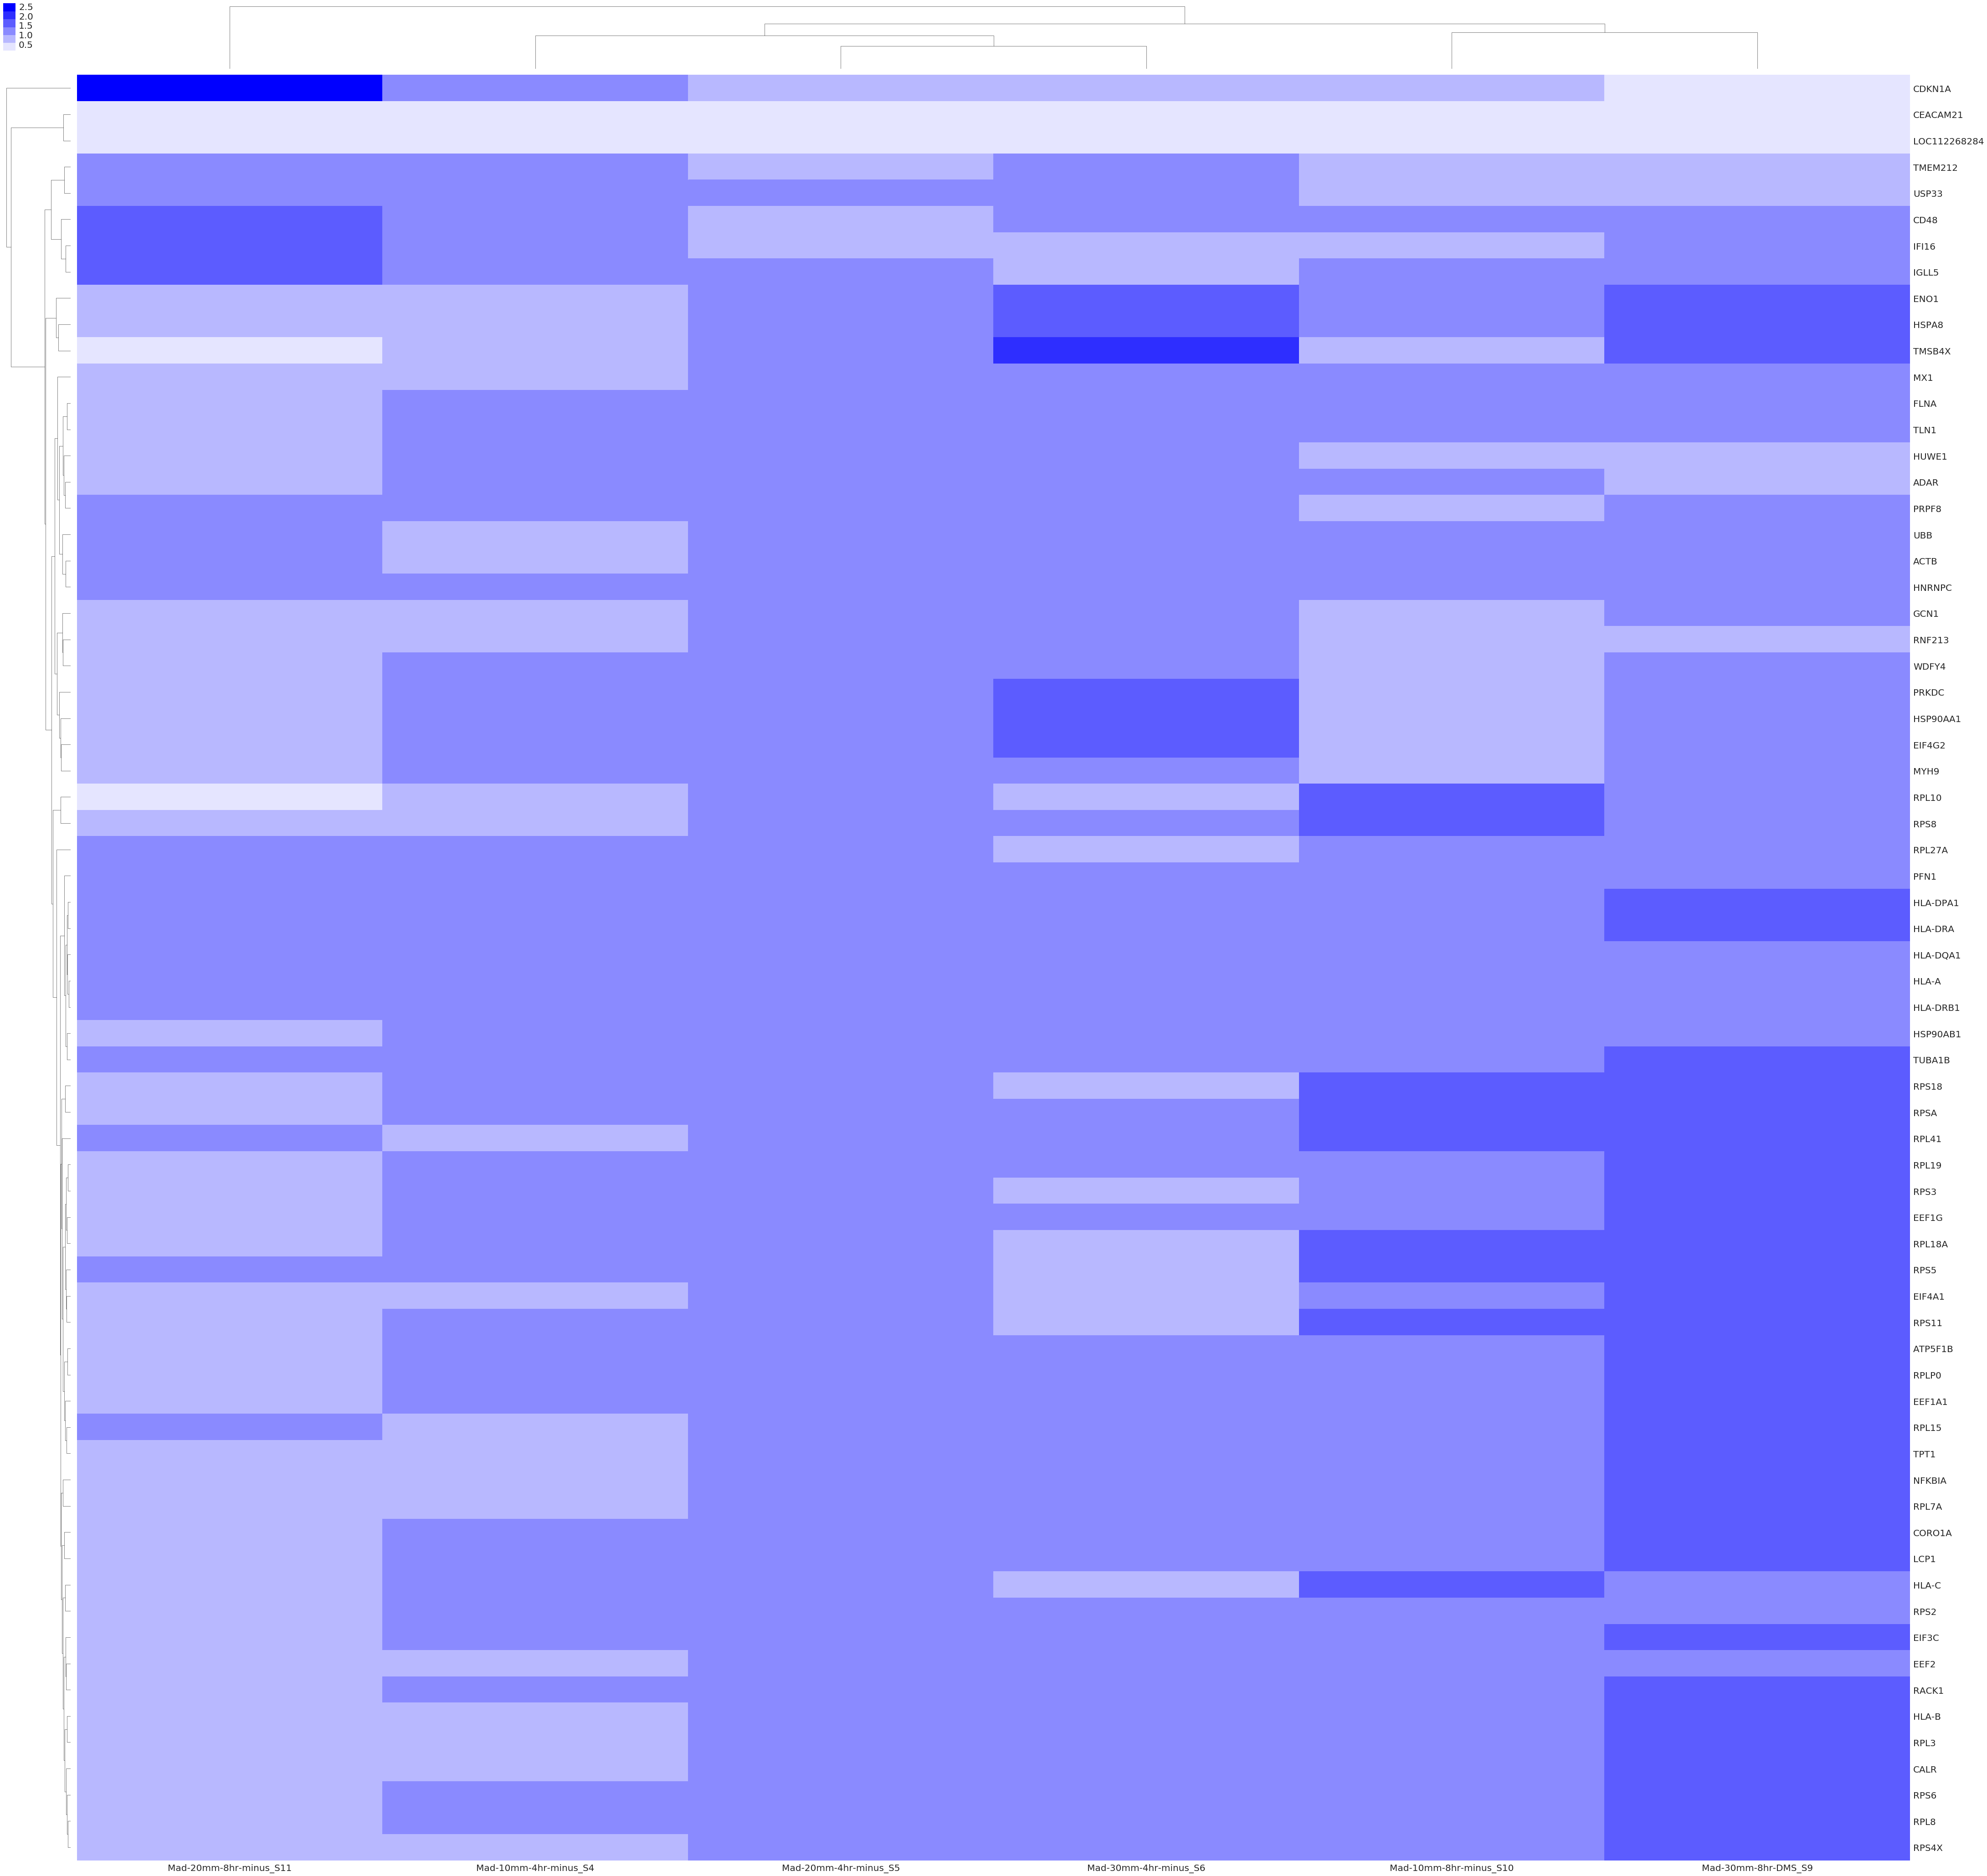

In [18]:
sns.set(font_scale=2)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/Ratio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [19]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

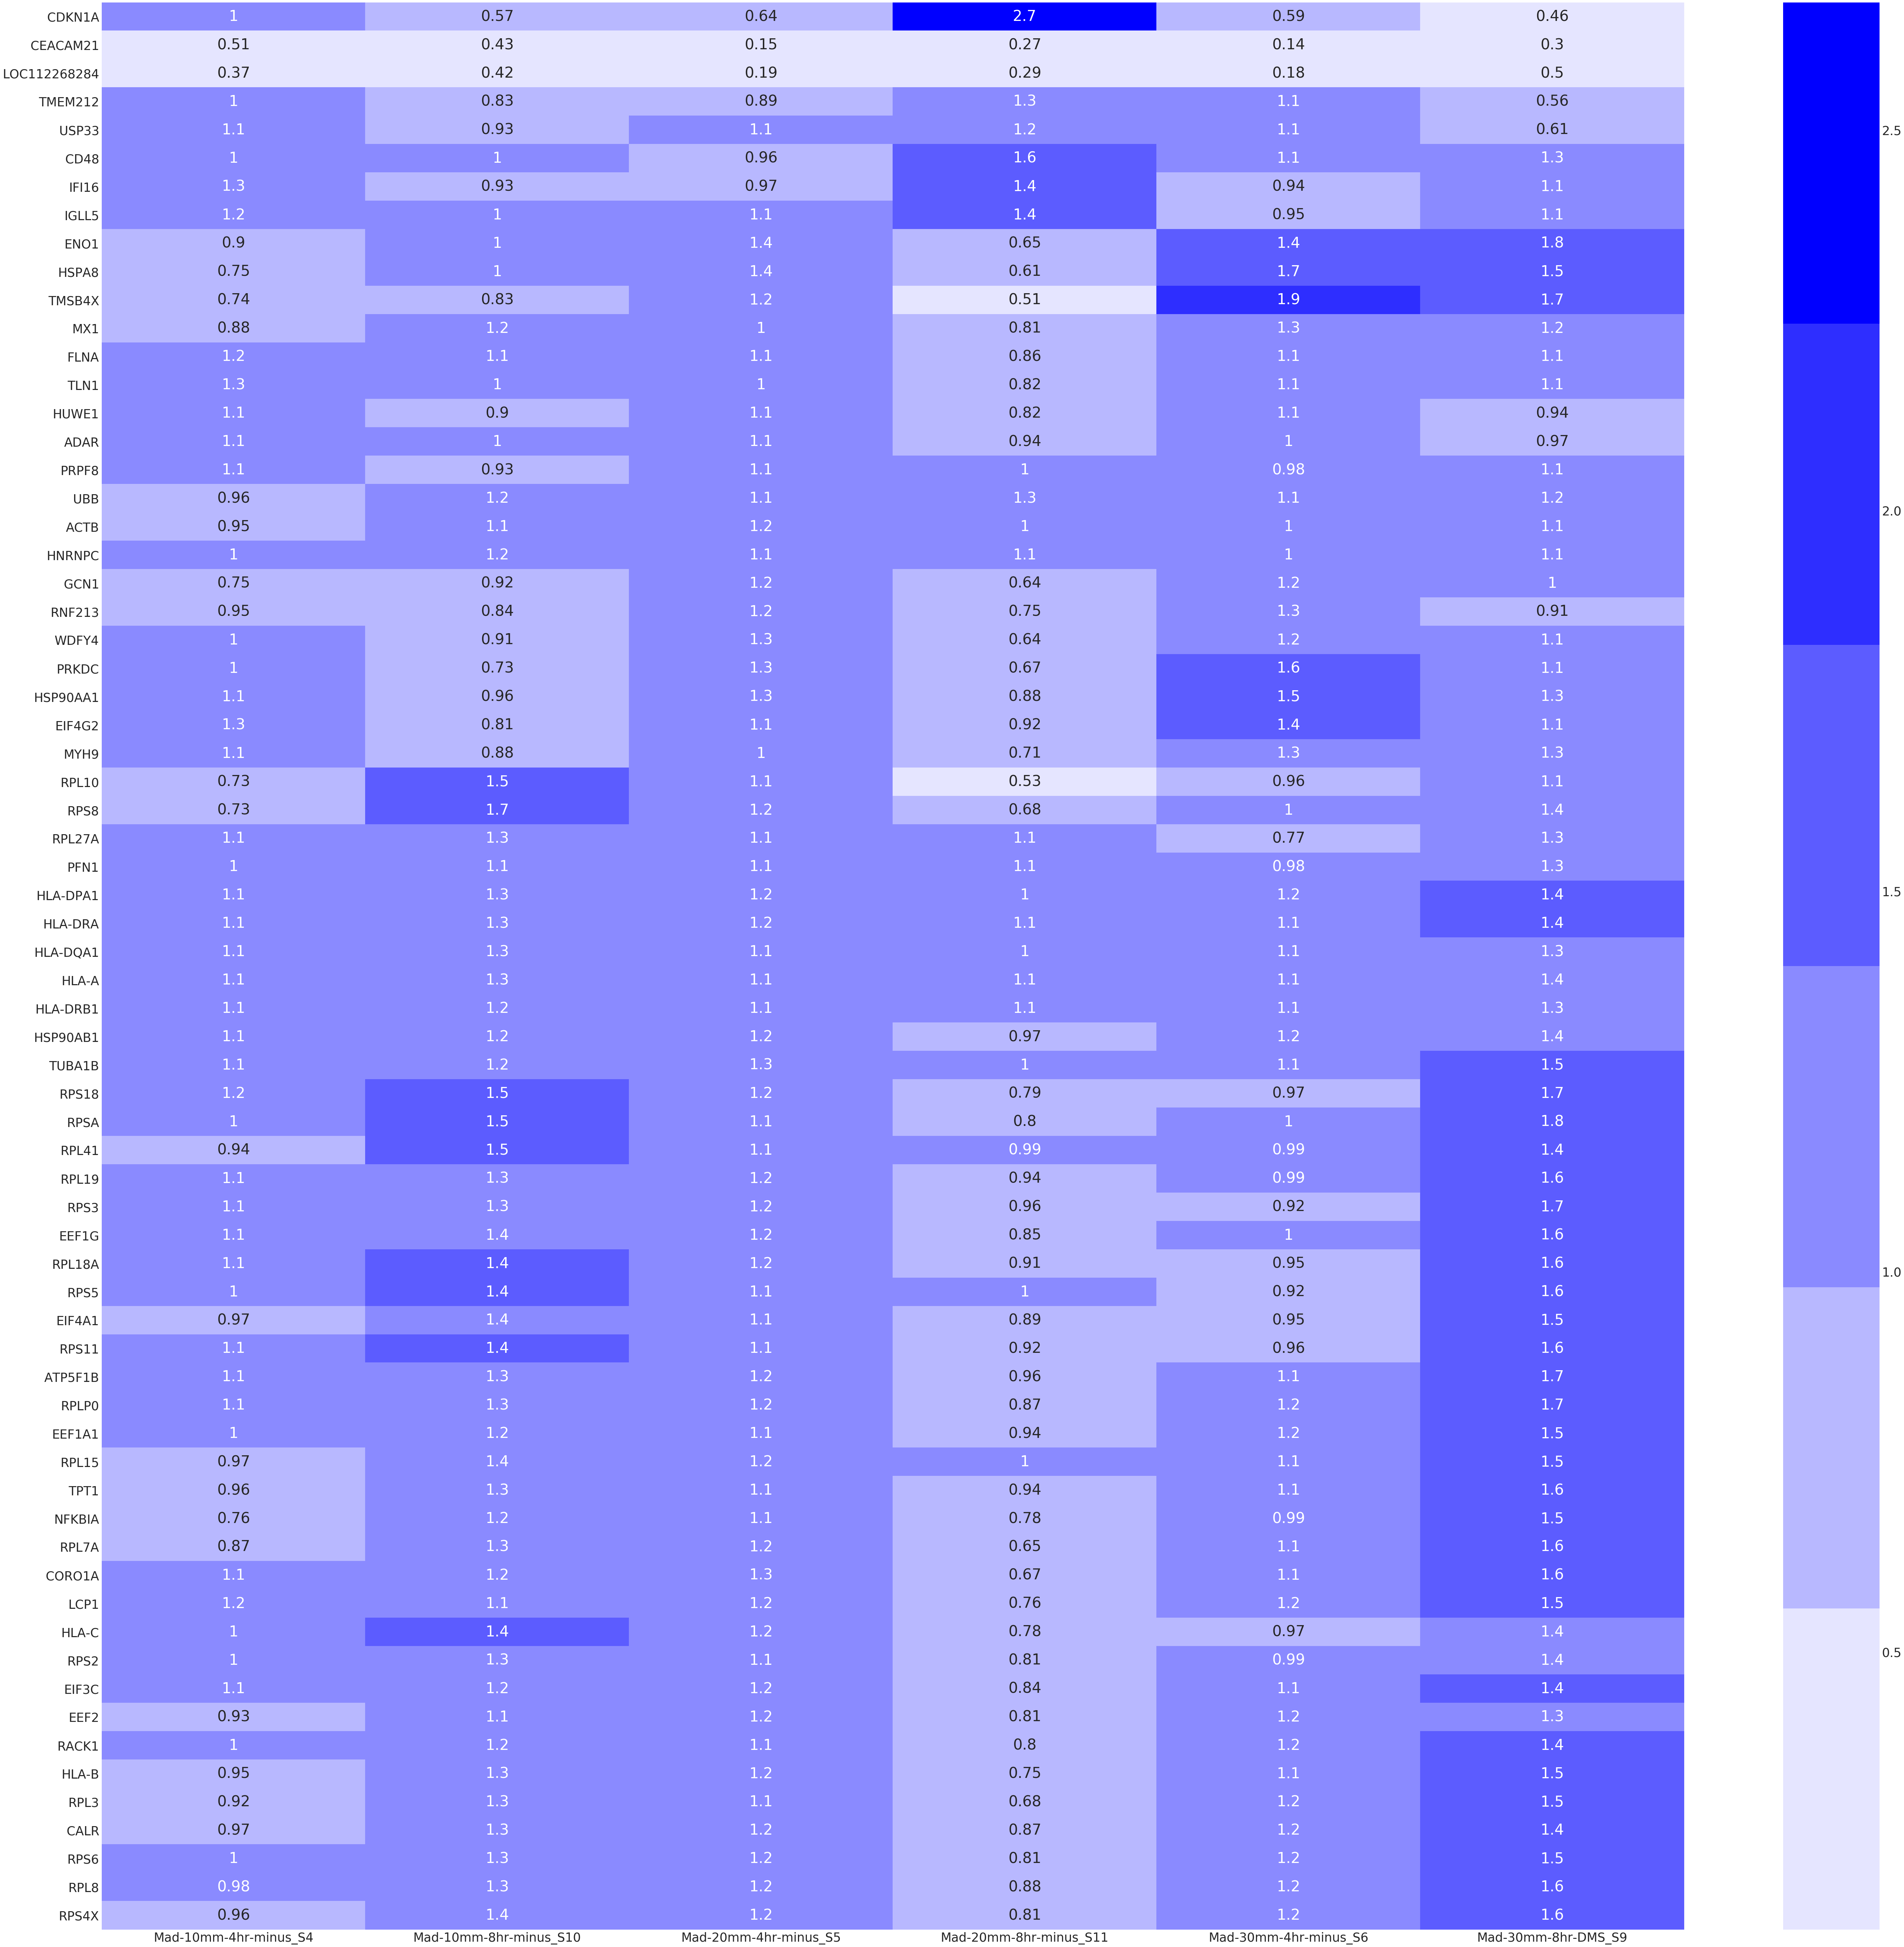

In [20]:
sns.set(font_scale=3.5)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax)
plt.savefig("../results/Ratio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")